In [1]:
import os
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import skimage.io
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
DATA_DIR = '../datasets/'
SAVE_DIR = './out/'

In [3]:
def draw_conv_filters(epoch, step, weights, save_dir):
    w = weights.copy()
    num_filters = w.shape[3]
    num_channels = w.shape[2]
    k = w.shape[0]
    assert w.shape[0] == w.shape[1]
    w = w.reshape(k, k, num_channels, num_filters)
    w -= w.min()
    w /= w.max()
    border = 1
    cols = 8
    rows = math.ceil(num_filters / cols)
    width = cols * k + (cols-1) * border
    height = rows * k + (rows-1) * border
    img = np.zeros([height, width, num_channels])
    for i in range(num_filters):
        r = int(i / cols) * (k + border)
        c = int(i % cols) * (k + border)
        img[r:r+k,c:c+k,:] = w[:,:,:,i]
    filename = 'epoch_%02d_step_%06d.png' % (epoch, step)
    ski.io.imsave(os.path.join(save_dir, filename), img)

def labels_to_onehot(Y_, C):
    N = Y_.shape[0]
    Yoh_ = np.zeros((N, C))
    Yoh_[range(N), Y_] = 1
    return Yoh_

def weight_variable(shape, stdev=0.1):
    # shape [dim_x, dim_y, num_of_input_channels, num_of_output_channels]
    initial = tf.truncated_normal(shape, stddev=stdev)
    return tf.Variable(initial)

def bias_variable(shape, initial=0.1):
    # shape: [num_of_output_channels]
    initial = tf.constant(initial, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    # x: input
    # W: weights
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool(x, k, stride):
    # x: input
    # k: window size
    # stride: window step
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, stride, stride, 1], padding='SAME')

### 3. zadatak - usporedba s Tensorflowom

In [4]:
# parameters
img_height = 28
img_width = 28
num_channels = 1
num_classes = 10

conv_k = 5
pool_k = 2
pool_stride = 2
hidden_layers = [16, 32, 512]

batch_size = 50
param_delta = 1e-4
param_niter = 20000
verbose = True
print_every = 1000

In [5]:
# load dataset
mnist = input_data.read_data_sets(DATA_DIR + 'MNIST/', one_hot=True)

Extracting ../datasets/MNIST/train-images-idx3-ubyte.gz
Extracting ../datasets/MNIST/train-labels-idx1-ubyte.gz
Extracting ../datasets/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../datasets/MNIST/t10k-labels-idx1-ubyte.gz


In [6]:
# inputs
x = tf.placeholder(tf.float32, shape=[None, img_height * img_width])
x_image = tf.reshape(x, [-1, img_height, img_width, num_channels])
y_ = tf.placeholder(tf.float32, shape=[None, num_classes])

# conv layer
W_conv1 = weight_variable([conv_k, conv_k, num_channels, hidden_layers[0]])
b_conv1 = bias_variable([hidden_layers[0]])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool(h_conv1, pool_k, pool_stride)

# conv layer
W_conv2 = weight_variable([conv_k, conv_k, hidden_layers[0], hidden_layers[1]])
b_conv2 = bias_variable([hidden_layers[1]])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool(h_conv2, pool_k, pool_stride)

# fc layer
W_fc1 = weight_variable([7*7*hidden_layers[1], hidden_layers[2]])
b_fc1 = bias_variable([hidden_layers[2]])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*hidden_layers[1]])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# readout layer
W_fc2 = weight_variable([hidden_layers[2], num_classes])
b_fc2 = bias_variable([num_classes])

y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2

# loss
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

# optimizer
train_step = tf.train.AdamOptimizer(param_delta).minimize(cross_entropy)

# accuracy
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# init session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

N = mnist.train.images.shape[0]
for i in range(param_niter):
    epoch = i * batch_size / N
    
    batch = mnist.train.next_batch(batch_size)
    
    _ = sess.run(train_step, feed_dict={x: batch[0], y_: batch[1]})

    if verbose and i % print_every == 0:
        train_accuracy = sess.run(accuracy, feed_dict={x: batch[0], y_: batch[1]})
        print('epoch %d, step %d, training accuracy %g' % (epoch, i, train_accuracy))

test_accuracy = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
print('test accuracy %g' % test_accuracy)

epoch 0, step 0, training accuracy 0.12
epoch 0, step 1000, training accuracy 0.98
epoch 1, step 2000, training accuracy 0.96
epoch 2, step 3000, training accuracy 0.96
epoch 3, step 4000, training accuracy 0.98
epoch 4, step 5000, training accuracy 1
epoch 5, step 6000, training accuracy 1
epoch 6, step 7000, training accuracy 0.98
epoch 7, step 8000, training accuracy 0.98
epoch 8, step 9000, training accuracy 1
epoch 9, step 10000, training accuracy 0.98
epoch 10, step 11000, training accuracy 0.98
epoch 10, step 12000, training accuracy 1
epoch 11, step 13000, training accuracy 1
epoch 12, step 14000, training accuracy 1
epoch 13, step 15000, training accuracy 1
epoch 14, step 16000, training accuracy 1
epoch 15, step 17000, training accuracy 0.98
epoch 16, step 18000, training accuracy 1
epoch 17, step 19000, training accuracy 1
test accuracy 0.9921


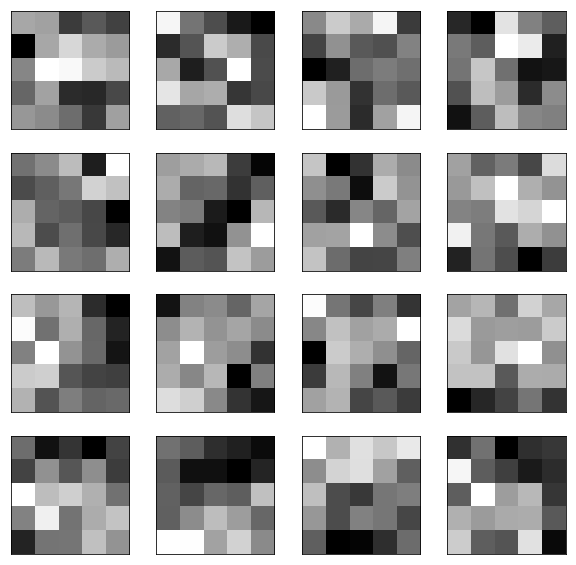

In [7]:
_, plots = plt.subplots(4, 4, figsize=(10, 10))
for i, plot in enumerate(plots.flatten()):
    feature = sess.run(W_conv1)[:,:,0,i]
    vmin = feature.flatten().min()
    vmax = feature.flatten().max()
    plot.matshow(feature, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
    plot.set_xticks([])
    plot.set_yticks([])
plt.show()

### 4. zadatak - Klasifikacija na CIFAR-10 skupu

In [8]:
# parameters
img_height = 32
img_width = 32
num_channels = 3
num_classes = 10

conv_k = 5
pool_k = 3
pool_stride = 2
hidden_layers = [16, 32, 256, 128]

batch_size = 50
param_delta = 1e-4
param_niter = 20000
verbose = True
print_every = 1000

In [9]:
# load dataset
def shuffle_data(data_x, data_y):
    indices = np.arange(data_x.shape[0])
    np.random.shuffle(indices)
    shuffled_data_x = np.ascontiguousarray(data_x[indices])
    shuffled_data_y = np.ascontiguousarray(data_y[indices])
    return shuffled_data_x, shuffled_data_y

def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

train_x = np.ndarray((0, img_height * img_width * num_channels), dtype=np.float32)
train_y = []
for i in range(1, 6):
    subset = unpickle(os.path.join(DATA_DIR, 'CIFAR-10/data_batch_%d' % i))
    train_x = np.vstack((train_x, subset['data']))
    train_y += subset['labels']
train_x = train_x.reshape((-1, num_channels, img_height, img_width)).transpose(0,2,3,1)
train_y = np.array(train_y, dtype=np.int32)

subset = unpickle(os.path.join(DATA_DIR, 'CIFAR-10/test_batch'))
test_x = subset['data'].reshape((-1, num_channels, img_height, img_width)).transpose(0,2,3,1).astype(np.float32)
test_y = np.array(subset['labels'], dtype=np.int32)

valid_size = 5000
train_x, train_y = shuffle_data(train_x, train_y)
valid_x = train_x[:valid_size, ...]
valid_y = train_y[:valid_size, ...]
train_x = train_x[valid_size:, ...]
train_y = train_y[valid_size:, ...]
data_mean = train_x.mean((0,1,2))
data_std = train_x.std((0,1,2))

train_x = (train_x - data_mean) / data_std
valid_x = (valid_x - data_mean) / data_std
test_x = (test_x - data_mean) / data_std

In [10]:
accuracies = []
losses = []

# inputs
x = tf.placeholder(tf.float32, shape=[None, img_height, img_width, num_channels])
y_ = tf.placeholder(tf.float32, shape=[None, num_classes])

# conv layer
W_conv1 = weight_variable([conv_k, conv_k, num_channels, hidden_layers[0]])
b_conv1 = bias_variable([hidden_layers[0]])

h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
h_pool1 = max_pool(h_conv1, pool_k, pool_stride)

# conv layer
W_conv2 = weight_variable([conv_k, conv_k, hidden_layers[0], hidden_layers[1]])
b_conv2 = bias_variable([hidden_layers[1]])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool(h_conv2, pool_k, pool_stride)

# fc layer
W_fc1 = weight_variable([8*8*hidden_layers[1], hidden_layers[2]])
b_fc1 = bias_variable([hidden_layers[2]])

h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*hidden_layers[1]])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# fc layer
W_fc2 = weight_variable([hidden_layers[2], hidden_layers[3]])
b_fc2 = bias_variable([hidden_layers[3]])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)

# readout layer
W_fc3 = weight_variable([hidden_layers[3], num_classes])
b_fc3 = bias_variable([num_classes])

y_conv = tf.matmul(h_fc2, W_fc3) + b_fc3

# loss
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

# optimizer
train_step = tf.train.AdamOptimizer(param_delta).minimize(cross_entropy)

# accuracy
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# init session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

N = train_x.shape[0]
for i in range(param_niter):
    epoch = i * batch_size / N
    
    from_index = (i * batch_size) % N
    to_index = from_index + batch_size
    batch = (train_x[from_index:to_index], labels_to_onehot(train_y[from_index:to_index], num_classes))
    
    _ = sess.run(train_step, feed_dict={x: batch[0], y_: batch[1]})

    if verbose and i % print_every == 0:
        conv1_weights, train_accuracy, loss = sess.run([W_conv1, accuracy, cross_entropy], feed_dict={x: batch[0], y_: batch[1]})
        accuracies.append(train_accuracy)
        losses.append(loss)
        draw_conv_filters(epoch, i, conv1_weights, SAVE_DIR + 'zad4/')
        print('epoch %d, step %d, training accuracy %g' % (epoch, i, train_accuracy))

test_accuracy = sess.run(accuracy, feed_dict={x: test_x[:5000], y_: labels_to_onehot(test_y[:5000], num_classes)})
print('test accuracy %g' % test_accuracy)

C:\Users\tzadr\Anaconda2\envs\ipykernel_py3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


epoch 0, step 0, training accuracy 0.06
epoch 1, step 1000, training accuracy 0.6
epoch 2, step 2000, training accuracy 0.58
epoch 3, step 3000, training accuracy 0.7
epoch 4, step 4000, training accuracy 0.64
epoch 5, step 5000, training accuracy 0.62
epoch 6, step 6000, training accuracy 0.66
epoch 7, step 7000, training accuracy 0.72
epoch 8, step 8000, training accuracy 0.68
epoch 10, step 9000, training accuracy 0.74
epoch 11, step 10000, training accuracy 0.82
epoch 12, step 11000, training accuracy 0.76
epoch 13, step 12000, training accuracy 0.88
epoch 14, step 13000, training accuracy 0.82
epoch 15, step 14000, training accuracy 0.78
epoch 16, step 15000, training accuracy 0.78
epoch 17, step 16000, training accuracy 0.84
epoch 18, step 17000, training accuracy 0.84
epoch 20, step 18000, training accuracy 0.86
epoch 21, step 19000, training accuracy 0.94
test accuracy 0.6828


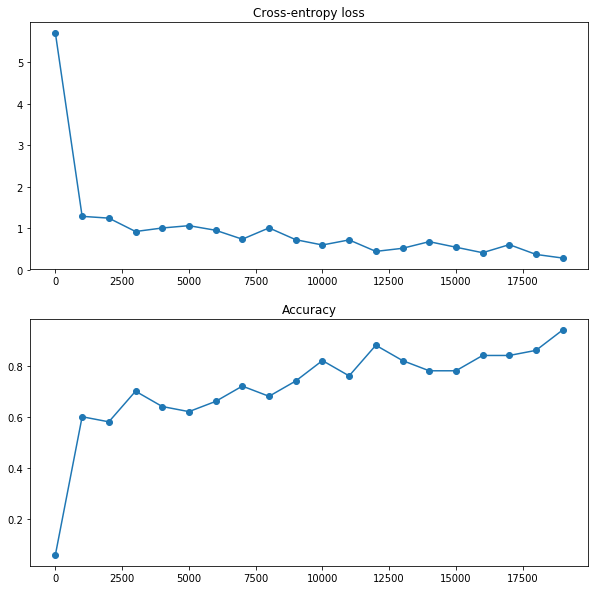

In [11]:
_, plots = plt.subplots(2, figsize=(10, 10))
    
plots[0].set_title('Cross-entropy loss')
plots[0].plot([i * print_every for i in range(len(losses))], losses, marker='o')

plots[1].set_title('Accuracy')
plots[1].plot([i * print_every for i in range(len(accuracies))], accuracies, marker='o')

plt.show()